## Introduction

A two-sided reputation system is a rating system in which each party rates the other (directly or indirectly). On Uber, Airbnb, eBay and other "sharing economy" platforms, customers rate service providers, and service providers rate customers. Sites such as Yelp and TripAdvisor also rely on customer ratings to recommend service providers such as hotels or restaurants, and weight ratings by the influence of the rater. 

Netflix, Amazon and others provide product recommender systems, in which the ratings go only one way. 

On the surface, two-sided reputation systems may look like product recommender systems. In each case the user typically enters a rating (out of five stars, perhaps) to show their opinion of the thing they are rating. But while a movie does not change in response to ratings, people can and do respond to being rated: they may get offended by a low rating, or may be grateful for a high rating. Those doing the rating are aware of this difference, and may take it into account as they make their rating. 

In the few years since they have become widespread, two-sided reputation systems have shown two seemingly contradictory characteristics:

1. The Lake Wobegon effect is that most ratings on reputation systems are very high. While ratings of Netflix movies peak around 3.5 out of 5, ratings on sharing economy websites are almost all positive (mostly five stars out of five). The oldest and most widely-studied reputation system is eBay, in which well over 90% of ratings are positive; other systems such as BlaBlaCar show over 95% of ratings as "five out of five".

2. The Panopticon effect: service providers live in fear of a bad rating. They are apprehensive that ratings given for the most frivolous of reasons by a customer they will never see again (and who may not be able to identify) may wreck their earnings opportunities, either by outright removal from a platform or by pushing them down the rankings in search recommendations. Yelp restaurant owners rail at "drive-by reviewers" who damage their reputation; Uber drivers fear being "deactivated" (fired), which can happen if their rating slips below 4.6 out of 5 (a rating that would be stellar for a movie).

So are reputation systems effective or not? Here's the seeming contradiction:

1. The Lake Wobegon effect suggests that reputation systems are useless: they fail to discriminate between good and bad service providers (my take on this from a couple of years ago is [here](http://tomslee.net/2013/09/some-obvious-things-about-internet-reputation-systems.html)). This suggestion is supported by quite a bit of recent empirical research which I have summarized in [MY NEW BOOK!](http://www.orbooks.com/catalog/whats-yours-is-mine-by-tom-slee/). Customers are treating reviews as a courtesy, rather than as an opportunity for objective assessment. Rather like a guest book, customers leave nice comments or say nothing at all.

2. The Panopticon effect suggests that rating systems are extremely effective in controlling the behaviour of service-providers, leading them to be customer-pleasing (sometimes extravagantly so) in order to avoid a damaging bad review.

For some time, I've wondered whether these two effects can really both exist at the same time, and if so what kind of incentives they introduce for both customers and service providers. So I've built a simple model reputation system that mimics both effects, and which shows that they are not contradictory after all, but can co-exist. I use this model to explore where the wider use of reputation systems is likely to take us. The short version is this:

- If we separate the impersonal market transaction aspect of a customer-provider experience from the social aspect, then the Lake Wobegon effect and the Panopticon effect are not contradictory at all. The transactional aspect is shaped by the provider's *competence* - a high competence leads to a good experience. The social aspect is shaped by the provider's (and customer's) *attitude* - what kind of person they are.

- Reputation systems do fail to discriminate among service providers of different competence, as the Lake Wobegon effect suggests.

- Reputation systems encourage customers to behave in an entitled, demanding manner rather than engaging in respectful relationship with service providers. 

- Reputation systems encourage providers to adopt a servile attitude, indulging customers' whims and performing what sociologists call "emotional labour".

- In summary, reputation systems do not improve quality so much as they impose a regime of servility on service providers.

## A Jupyter notebook

This document is a [Jupyter notebook](http://jupyter.org/) (previously called an iPython notebook). The code for the model is included as part of the document, and the graphs that show the results are generated using the code in the document. If you want to reproduce or extend this model, you can save the notebook, install the right packages in a Python distribution, and run it on your own computer. In addition to the requirements for Jupyter, you will need to install the following packages in a Python 3 environment:

In [13]:
# imports and setup
%matplotlib inline
import random # random number generation (included with pyuthon)
import numpy as np # numerical libraries used by matplotlib
import matplotlib # plotting libraries
import matplotlib.pyplot as plt # more plotting libraries
import pandas as pd # data analysis library
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

## A model reputation system

Rating people is different to rating movies. When we watch a movie the relationship is one way (the movie does not interact with us), but when we interact with others we enter into a two-way relationship. In some cases this relationship is brief and not likely to be repeated: taking a taxi or an Uber ride, eating in a fast-food restaurant in a city you are passing through. In other cases the relationship is richer and repeated: a stay at a Bed & Breakfast or an Airbnb (in a case where the host is present) may extend over days; a regular customer at a restaurant may get to know the staff; a relationship with a hairdresser or car mechanic may extend over years.

We now know, empirically, that the richer the customer-provider relationship, the more likely the reputation system is to show a large number of high ratings. When customers engage in a social relationship rather than a simple market transaction, they are reluctant to give negative ratings no matter what ther experience. The rating becomes, in effect, one part of the customer-provider relationship rather than an objective review.

Here, I try to build a model that captures the essence of customer and provider behaviour in a simple reputation system. Customers have the opportunity to rate providers after each exchange. Each exchange, in turn, has components:

- a market exchange component, in which the customer's satisfaction depends on the provider's competence (provider competence is fixed).
- a social component, in which the customer and provider engage in a give-and-take exchange that make extend over several interactions. To get technical for a moment, this social component is modelled as a repeated prisoner's dilemma, with the customer satisfaction and the provider satisfaction determined by the prisoner's dilemma payoffs. More details will become clear in the "Code walkthrough" sections below.

Most reputation systems use five-star ratings, but I simplify this to a simple "thumbs up/thumbs down" binary option. Some reputation systems allow providers to rate customers as well, and there are other variants (are ratings private? do actors see the rating before they give their own?) but even when service providers can rate customers there is an asymmetry at work, in that the service provider has more at stake in the rating. Adopting a one-way system is, I contend, a reasonable simplification to produce a simple and generic model.

With that summary, the next section (*Code walkthrough*) spells out the details of the model, and the following section (*Simulations*) runs several simulations of customers rating providers under various conditions. The document then concludes.

# Code walkthrough

Here is an annotated implementation of the model. If you don't know python and are not interested in reading the code, the commentary should spell out what's going on in this model reputation system. If you are really not interested in this, the next section should be comprehensible without reading this.

## Parameters

Start with some constants that define the various things used elsewhere, in an attempt to make the rest of the code more legible. You can probably ignore these for now.

In [14]:
# The choices available to the customer and provider in their social exchange
CHOICE_GIVE = 0
CHOICE_TAKE = 1

# The payoffs in the prisoner's dilemma. 
PAYOFF_GIVE_VERSUS_GIVE = 1.0 
PAYOFF_GIVE_VERSUS_TAKE = 0.0
PAYOFF_TAKE_VERSUS_GIVE = 1.5
PAYOFF_TAKE_VERSUS_TAKE = 0.5

# Attitudes (prisoner's dilemma strategies)
ATTITUDE_GIVE = "Give"
ATTITUDE_GIVE_AND_TAKE = "Give & Take"
ATTITUDE_TAKE = "Take"

# The customer rates the provider
RATING_THUMBS_UP = 1.0
RATING_THUMBS_DOWN = -1.0

## Actors

Each customer or provider is an *actor*. The Actor() object represents the basic things we need to know about each customer and provider. 

Each actor has an *attitude*, which is expressed in their choices. (In game theoretic terms, each has a strategy expressed in the method called choose()). An actor's attitude is fixed for the course of a simulation. The attitude determines how the actor behaves during each customer-provider interaction.

In each interaction, both actors choose one of GIVE or TAKE. Then they actors gain or lose satisfaction depending on the choices, with the "payoffs" of satisfaction corresponding to the prisoner's dilemma outcomes. If each actor chooses GIVE, that is better for each of them than if both choose TAKE. However, the best of all for an actor is to choose TAKE while the other actor chooses GIVE. To keep things simple, only a very few attitudes are considered:

- Give: (provider only). The provider plays GIVE on every interaction. The provider is compliant, or servile (or "customer is always right"), putting in full effort no matter how demanding the customer is. This is a provider prepared to endure the whims of the customer, engaging in "emotional labour".
- Give & Take: (customer or provider) This attitude seeks to encourage co-operative behaviour between customer and provider, and represents a collaborative, approach to self-governance (generous, but standing up for yourself if the other actor turns nasty). The customer plays GIVE on the first interaction, and after that plays by the "golden rule", returning GIVE with GIVE and TAKE with TAKE, (This is the "Tit for Tat" strategy for prisoner's dilemma).
- Take: (customer only). This attitude simply plays TAKE at every opportunity, no matter how the provider behaves. This customer is looking out for themselves, no messing around.

The model can be extended easily so that both customers and providers may adopt any of the three attitides (Give, Give & Take, Take), and the code does work for that, but I've not discussed it here.

So here are the Actor declarations:

In [15]:
class Actor():
       
    def __init__(self, actor_attitude):
        self.attitude = actor_attitude
        self.satisfaction = 0.0 # start off at zero satisfaction
        self.exchanges = 0.0 # how many exchanges has the actor seen
        self.previous_choice = None
        self.exchange_score = 0 # score in a current exchange
            
    def choose(self, prev_opponent_choice):
        if self.attitude == ATTITUDE_GIVE:
            choice = CHOICE_GIVE
        elif self.attitude == ATTITUDE_GIVE_AND_TAKE:
            if prev_opponent_choice is None:
                choice = CHOICE_GIVE 
            else:
                choice = prev_opponent_choice
        elif self.attitude == ATTITUDE_TAKE:
            choice = CHOICE_TAKE
        
        # Commented out, but you can re-instate if you want to explore this
        # Notwithstanding the above, a fraction of choices are random, for both 
        # customer and provider. This represents misunderstanding and prevents
        # artifical fragile equilibria from playing too big a part in the outcome
        #if random.random() < noise_fraction:
        #    choice = random.choice([CHOICE_GIVE, CHOICE_TAKE])

        return choice

## Customers and providers

Customers and providers are both Actors, but the provider has additional characteristics: a *competence* in providing their service, and a *reputation* (from the customers' assessments). The rating system used here is a simple thumbs up or thumbs down choice, and it is also helpful to track the number of each that a provider has accumulated: the reputation can be computed from these as the fraction of thumbs up ratings.

In [16]:
class Customer(Actor):

    def __init__(self, attitude):
        Actor.__init__(self, attitude)
        
class Provider(Actor):
    
    def __init__(self, attitude):
        Actor.__init__(self, attitude)
        self.rating = 0.0 # +1 for each THUMBS_UP, -1 for each THUMBS_DOWN
        self.rating_count = 0.0
        self.competence = None
        
    def reputation(self):
        # Value in the range [-1, +1]
        if self.rating_count > 0:
            return (self.rating / self.rating_count)
        else:
            return 0 # no ratings, no reputation

## A customer-provider interaction

Now we have customer and provider objects, we can model an interaction between the two. Each individual interaction between a customer and a provider is modelled as a single play of the prisoner's dilemma. The end result of each interaction is a score for the customer and for the provider representing their overall satisfaction with the interaction.

We'll see what kind of experience an interaction may represent after the next definition, of an *exchange*. Here is a function for an individual interaction:

In [17]:
def interact(customer, provider):
    # Each interaction in an exchange is a single play of the prisoner's dilemma
    # each actor makes a choice
    # Prisoner's dilemma choices: co-operate or defect
    customer_choice = customer.choose(provider.previous_choice)
    provider_choice = provider.choose(customer.previous_choice)
    # now compute the payoffs
    if customer_choice == CHOICE_GIVE:
        if provider_choice == CHOICE_GIVE:
            customer_score = PAYOFF_GIVE_VERSUS_GIVE
            provider_score = PAYOFF_GIVE_VERSUS_GIVE
        elif provider_choice == CHOICE_TAKE:
            customer_score = PAYOFF_GIVE_VERSUS_TAKE
            provider_score = PAYOFF_TAKE_VERSUS_GIVE
    elif customer_choice == CHOICE_TAKE:
        if provider_choice == CHOICE_GIVE:
            customer_score = PAYOFF_TAKE_VERSUS_GIVE
            provider_score = PAYOFF_GIVE_VERSUS_TAKE
        elif provider_choice == CHOICE_TAKE:
            customer_score = PAYOFF_TAKE_VERSUS_TAKE
            provider_score = PAYOFF_TAKE_VERSUS_TAKE
    return (customer_choice, provider_choice, customer_score, provider_score)

## A customer-provider exchange

Each customer-provider exchange has a transactional component and a social exchange component. The social exchange is made up of a number of interactions (see above).

During each exchange the customer and provider gain or lose *satisfaction*. This satisfaction has a social component, which marks their satisfaction (or otherwise) at the interaction itself, and a transactional component, which is based on the provider's competence. If the exchange is a guest staying with a host, then each interaction might be the welcome, a meal, a conversation. If the exchange is a hairdresser and a customer, then the exchange may represent a long relationship, with each interaction being a visit. Of course, this is very schematic, but the idea is that rich exchanges can be modelled with many interactions, while a thin exchange may be a simple interaction.

At the end of the exchange, the customer has the opportunity to rate the provider (THUMBS_UP or THUMBS_DOWN). How the customer rates depends on the experience, and also on what kind of person the customer is (their attitude).

A satisfying experience depends on the quality of service (represented here as the competence of the provider), but also on the social aspect of the interaction. Researchers have found that when dealing with service providers, most customers care more about the service provider's attitude than about their competence; more about what kind of person they are than about the transaction.

Provider competence does matter when evaluating the provider, but the importance of that aspect of the exchange is higher when the social aspect is less important -- when there are few interactions in the exchange -- and less important as the social aspect becomes richer.

If the customer decides they have had a good experience (based on the outcome of both the social exchange and the market exchange), then the customer will give a THUMBS_UP rating. For customers who have had a bad experience, the behaviour is different for each attitude:

- Customers playing Give & Take, who treat the exchange as a relationship, do not give a bad rating if they have a bad experience; they simply give no rating at all, not wanting the awkwardness of engaging in critisicm. There is strong evidence that this is how many people actually behave in sharing economy reputation systems.
- Customers playing Take, who focus on the market transaction will give a THUMBS_DOWN rating if they have a bad experience.

Here is a function that describes a customer-provider exchange:

In [18]:
def experience_exchange(customer, provider, interactions):
    # an exchange between a customer and provider, consisting
    # of multiple interactions
    for interaction in range(interactions):
        (customer.previous_choice, provider.previous_choice,
         customer_score, provider_score) = interact(customer, 
                                                    provider)
        customer.exchange_score += customer_score
        provider.exchange_score += provider_score
    # normalize to a range between 0 and 1.5 (social bit is difficult)
    customer.exchange_score = customer.exchange_score / interactions
    provider.exchange_score = provider.exchange_score / interactions
    
def rate_exchange(customer, provider, interactions):
    # to conclude the exchange, the customer may rate the provider
    # Competence becomes less importance as the number of interactions grows.
    # Update utilities
    threshold_score = 0.75
    mean_competence = 0.5
    satisfaction_threshold = (threshold_score + mean_competence)/2.0
    # track each actor's overall satisfactin throughout all their exchanges
    tolerance = 0.00001 # deal with floating point comparisons
    
    if (customer.exchange_score  > satisfaction_threshold - tolerance):
        good_experience = True
    else:
        good_experience = False
    if customer.attitude == ATTITUDE_GIVE_AND_TAKE:
        # only report good outcomes
        if good_experience:
            provider.rating_count += 1.0
            provider.rating += RATING_THUMBS_UP
    elif customer.attitude == ATTITUDE_GIVE:
        # always give a good rating, no matter what
        provider.rating_count += 1.0
        provider.rating += RATING_THUMBS_UP
    elif customer.attitude == ATTITUDE_TAKE:
        # tell the truth
        provider.rating_count += 1.0
        if good_experience:
            provider.rating += RATING_THUMBS_UP
        else:
            provider.rating += RATING_THUMBS_DOWN
            
def exchange(customer, provider, interactions):
    for actor in [customer, provider]:
        actor.exchanges += 1.0
        actor.exchange_score = 0.0
        actor.previous_choice = None
    customer.exchange_score = provider.competence # transaction satisfaction
    if interactions > 0:
        experience_exchange(customer, provider, interactions)
    rate_exchange(customer, provider, interactions)
    customer.satisfaction += customer.exchange_score
    provider.satisfaction += provider.exchange_score

## A rating period

Each simulation is run over a number of *rating periods*.  In each rating period, every customer chooses a provider and they have an exchange. Depending on the number of customers and providers, this may mean that a provider undertakes several exchanges, one, or none.

The customer ratings are collected together as a *reputation* score for each provider, and the higher a provider's reputation, the better their chance of being chosen by a customer in the next rating period. In this way, the reputation feeds into the provider's life story.

Here is the function that describes a rating period:

In [19]:
def rating_period(period, sim):
    # Match up customers with providers: many customers may undertake an exchange with one provider
    # in a single period.
    # First assign ranges weighted by reputation
    maximum = 0.0
    store_front_max = [] # a list of values partitioning a range so that exchanges can be matched
    for provider in sim.providers:
        maximum +=  2.0 + provider.reputation()
        store_front_max.append(maximum)
        
    # Each customer chooses a provider and undertakes an exchange with them
    for customer in sim.customers:
        # choose a value between zero and the maximum
        val = random.uniform(0.0, maximum)
        # find which provider it is (inefficiently)
        for provider_id in range(len(sim.providers)):
            if val <= store_front_max[provider_id]:
                break
        exchange(customer, 
                 sim.providers[provider_id], 
                 sim.interactions_per_exchange)

## A complete simulation run

To run a complete simulation,the parameters that govern the simulation are specified in the constructor for the Simulation oject, and then Simulation.simulate() is called to carry out the simulation. The results of the simulation are stored in the Simulation object so they can be analyzed:

In [20]:
class Simulation():

    def __init__(self,
                customer_counts,
                provider_counts, # dict of {"attitude": count}
                rating_periods,
                interactions_per_exchange):
        self.rating_periods = rating_periods
        self.interactions_per_exchange = interactions_per_exchange
        self.customers = []
        self.customer_attitudes = []
        random.seed(1)  

        for attitude, count in customer_counts.items():
            if attitude not in self.customer_attitudes:
                self.customer_attitudes.append(attitude)
            for i in range(count):
                self.customers.append(Customer(attitude))
        self.providers = []
        self.provider_attitudes = []
        
        for attitude, count in provider_counts.items():
            if attitude not in self.provider_attitudes:
                self.provider_attitudes.append(attitude)
            for i in range(count):
                self.providers.append(Provider(attitude))
        # assign competence uniformly in (0,1) but randomly 
        shuffled_providers = list(range(len(self.providers)))
        random.shuffle(shuffled_providers)
        for index, provider_id in enumerate(shuffled_providers):
            self.providers[provider_id].competence = ((index + 1.0) /
                                                      (len(self.providers) + 1.0))
        
    def simulate(self):
        for period in range(self.rating_periods):
            rating_period(period, self)

## Plotting functions

These plotting functions generate graphs to help make sense of the simulations. You can ignore them.

In [32]:
def plot_by_competence(sim):
    dfp = pd.DataFrame({
        "attitude": pd.Series([provider.attitude for provider in sim.providers]),
        "competence": pd.Series([provider.competence for provider in sim.providers]),
        "satisfaction": pd.Series([provider.satisfaction / provider.exchanges 
                              for provider in sim.providers]),
        "exchanges": pd.Series([provider.exchanges for provider in sim.providers]),
        "reputation": pd.Series([provider.reputation() for provider in sim.providers]),
    })
    markers = ('o', 'o', '*')
    colors = ('red', 'blue', 'green', 'black')
    (marker_size, width, opacity) = (50, 0.8, 0.6)
    fig, axes = plt.subplots(1, 4, figsize=(12, 3)) # rows, cols
    plt.style.use('ggplot')
    # plot one set of points on each axis, for each provider attitude
    
    dfp["reputation"].plot(kind="hist", alpha=opacity, ax=axes[0], xlim=[-1.1,1.1], title="A1")
    axes[0].set_xlabel('Provider Reputation')
    axes[0].set_ylabel("Number of providers")
    for index, attitude in enumerate(sim.provider_attitudes):
        dfp[dfp["attitude"] == attitude].plot(
            kind="scatter", x= "competence", y = "satisfaction", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity,
            ax=axes[1], xlim=[-0.1,1.1], title="A2")
        dfp[dfp['attitude'] == attitude].plot(
            kind="scatter", x= "competence", y = "reputation", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, 
            ax=axes[2], xlim=[-0.1,1.1], title="A3")
        dfp[dfp['attitude'] == attitude].plot(
            kind="scatter", x= "competence", y = "exchanges", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, 
            ax=axes[3], label = attitude, xlim=[-0.1,1.1], title="A4")
    axes[1].set_xlabel('Provider Competence')
    axes[1].set_ylabel('Provider Satisfaction')
    axes[2].set_xlabel('Provider Competence')
    axes[2].set_ylabel('Provider Reputation')
    axes[3].set_xlabel('Provider Competence')
    axes[3].set_ylabel('Exchanges')
    axes[3].legend(fancybox=True, shadow=True, frameon=True, 
                   loc='upper left', bbox_to_anchor=(1.05, 1.0));
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()   
    
def plot_by_attitude(sim):
    dfc = pd.DataFrame({
        "attitude": pd.Series([customer.attitude for customer in sim.customers]),
        "satisfaction": pd.Series([customer.satisfaction / customer.exchanges 
                              for customer in sim.customers]),
        "exchanges": pd.Series([customer.exchanges for customer in sim.customers]),
    })
    dfp = pd.DataFrame({
        "attitude": pd.Series([provider.attitude for provider in sim.providers]),
        "satisfaction": pd.Series([provider.satisfaction / provider.exchanges 
                              for provider in sim.providers]),
        "reputation": pd.Series([provider.reputation() for provider in sim.providers]),
        "exchanges": pd.Series([provider.exchanges for provider in sim.providers]),
    })
    # sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
    (width, opacity) = (0.4, 0.6)
    fig, axes = plt.subplots(1, 4, figsize=(12, 4)) # rows, cols
    # plt.setp(fig.axes, xticklabels=sim.customer_attitudes)
    plt.style.use('ggplot')
    for i in range(len(axes)):
        axes[i].set_xlabel("Attitude")
    df0 = pd.pivot_table(dfc, index=["attitude"], values="satisfaction")
    df0.plot(ax=axes[0], kind="bar", alpha=opacity, width=width, title="B1")
    axes[0].set_ylabel("Customer Satisfaction")
    df1 = pd.pivot_table(dfp, index=["attitude"], values="satisfaction")
    df1.plot(ax=axes[1], kind="bar", alpha=opacity, width=width, title="B2")
    axes[1].set_ylabel("Provider Satisfaction")
    df2 = pd.pivot_table(dfp, index=["attitude"], values="reputation")
    df2.plot(ax=axes[2], kind="bar", alpha=opacity, width=width, ylim=[-1.0,1.0], title="B3")
    axes[2].set_ylabel("Provider Reputation")
    df3 = pd.pivot_table(dfp, index=["attitude"], values="exchanges")
    df3.plot(ax=axes[3], kind="bar", alpha=opacity, width=width, title="B4")
    axes[3].set_ylabel("Exchanges per Provider")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()      

# Simulations

The model description is now complete, and we can run some simulations. Recall that the point of this exercise is to investigate reputation systems that display two seemingly-contradictory phenomena seen in the real world: the Lake Wobegon effect in which (almost) everybody is given a high rating, and the Panopticon effect in which service providers live in fear of a bad rating. In particular:

- what qualities does such a system encourage in providers? (level of competence, attitude)
- which customers are getting what they want?

## Simulation 1: commodity exchange

In the first simulation there is no social aspect to the exchange (*interactions_per_exchange = 0*) so the reputation of each provider depends on their competence. The exchange is just like a market transaction for a commodity: there is no back and forth between customer and provider. The following code block assigns 240 customers to the Take attitude (they will rate positive experiences and negative experiences), distributes 80 providers evenly between "Give & Take" and the more indulgent "Give" attitudes, and runs them through 100 rating periods.

(Please ignore the pink warning box: this is a bug in matplotlib that will be fixed soon).

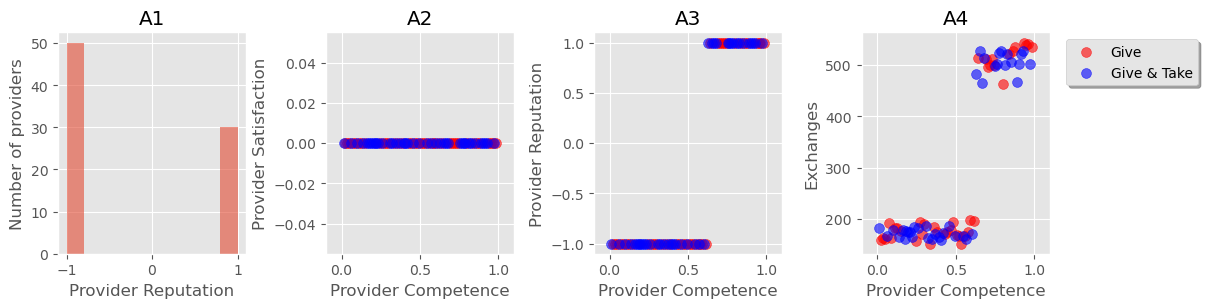

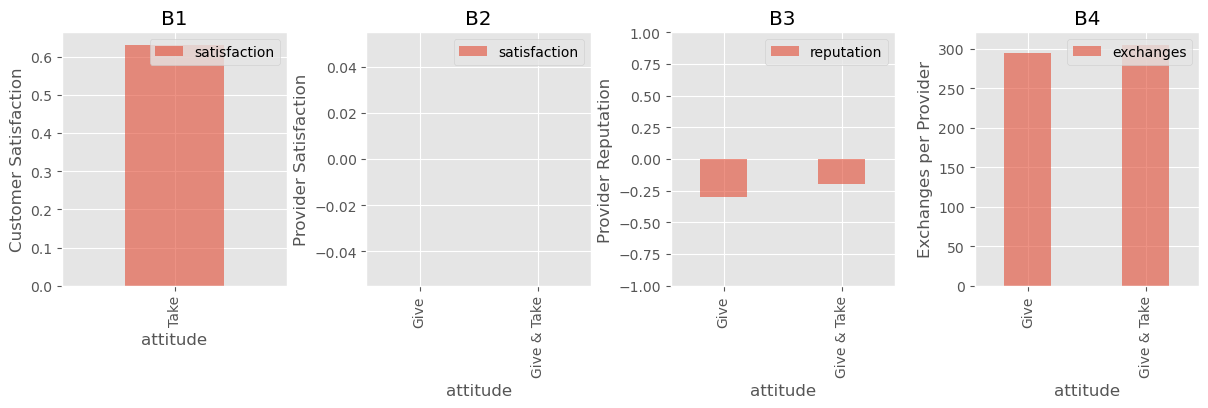

In [34]:
sim = Simulation(
    customer_counts = {ATTITUDE_TAKE: 240},
    provider_counts = {ATTITUDE_GIVE: 40, ATTITUDE_GIVE_AND_TAKE: 40},
    rating_periods = 100,
    interactions_per_exchange = 0
    )
sim.simulate()
plot_by_competence(sim)
plot_by_attitude(sim)

### Simulation 1 commentary

In this case, attitude is irrelevant because there is no relationship. A3 and B3 show that providers with a sub-par competence get rated badly and have a reputation of minus-one, while providers with a greater-than-average competence get rated with a thumbs-up by everyone.

This reputation carries over into the number of exchanges that each provider gets: those with a good reputation get around 200 visits from customers, while those with a good reputation mostly get about 500: competent providers get more business (A4). Meanwhile, attitude is irrelevant (B4).

In this special case the charts of provider satisfaction (A2, B2) are irrelevant because provider satisfaction comes only from the social aspect of the exchange, and in this case there is no social aspect.

This is how reputation systems are supposed to work, but it is not how reputation systems work in the real world, where most providers get good reputations and where the correlation of competence and reputation is weak. Figure A1 shows a distribution of ratings in which many providers have been given a bad reputation, completely unlike most real-world reputation systems.

## Simulation 2: Lake Wobegon ratings

This simulation looks at the other extreme, where the provider's competence is unimportant and the social relationship is all that matters. Just as we don't rate friends based on their skills (except perhaps in extreme circumstances), but on their personality and integrity, so competence is not important here.

The simulation again has 240 customers and 80 providers (as weill all the simulations) and the providers are again evenly distributed between being "Give & Take", and being servile ("Give"). Again there are 100 rating periods, but this time there are 25 interactions to every exchange, so the social aspect of the exchange overwhelms the market aspect.

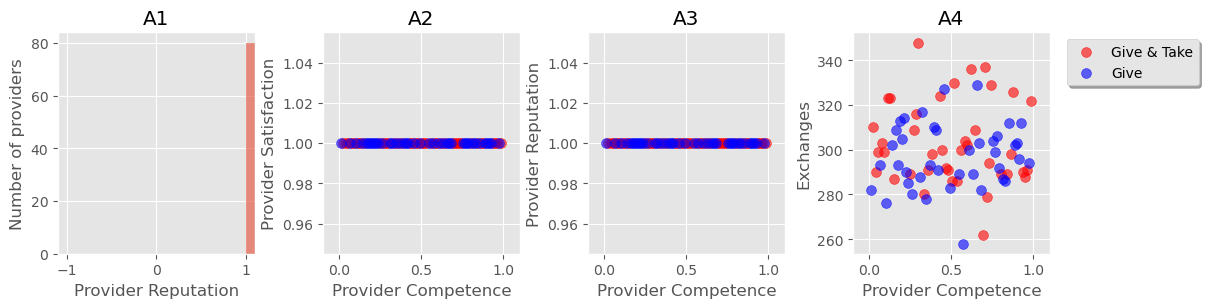

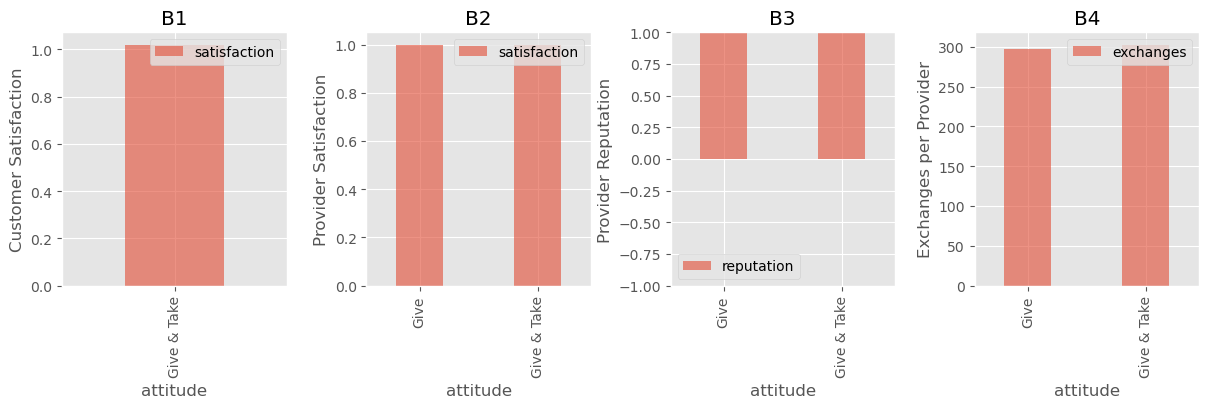

In [35]:
sim = Simulation(
    customer_counts = {ATTITUDE_GIVE_AND_TAKE: 240},
    provider_counts = {ATTITUDE_GIVE_AND_TAKE: 40, ATTITUDE_GIVE: 40},
    rating_periods = 100,
    interactions_per_exchange = 25
    )
sim.simulate()
plot_by_competence(sim)
plot_by_attitude(sim)

### Simulation 2 commentary 

A1 shows that all providers have a very high reputation (Lake Wobegon). A3 confirms that this high reputation means nothing: it does not distinguish based on competence or on attitude, because the "Give & Take" customers only give good ratings, keeping bad experiences to themselves. The reputation system is weak, and A4 shows that there is no correlation between competence, attitude, and the number of exchanges a provider gets.

But that does not mean that things are bad. B1 shows that customers get a high level of satisfaction (0.9) from the relationship aspect of the exchange - the mutual cooperation of provider and customer. B2 shows that  providers also do well (0.7 or more). So things are good, but different. This describes a self-governing system, where reputation does not matter, but customer and provider each induce the other to be generous.

## Simulation 3: introducing entitled customers

Now make one change: instead of all customers displaying a Give & Take attitude, one in ten will be demanding, and will play TAKE on all aspects of the exchange. Even though the exchange is primarily social, they may rate positively if they get a good outcome (which means, if the provider is compliant) or badly if they do not.

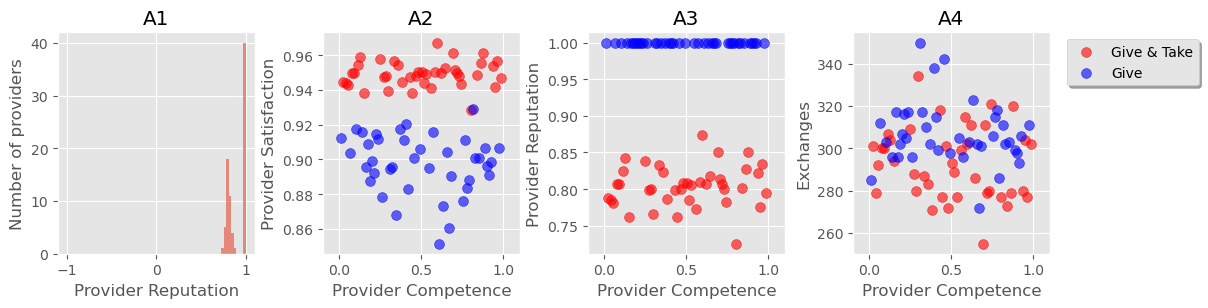

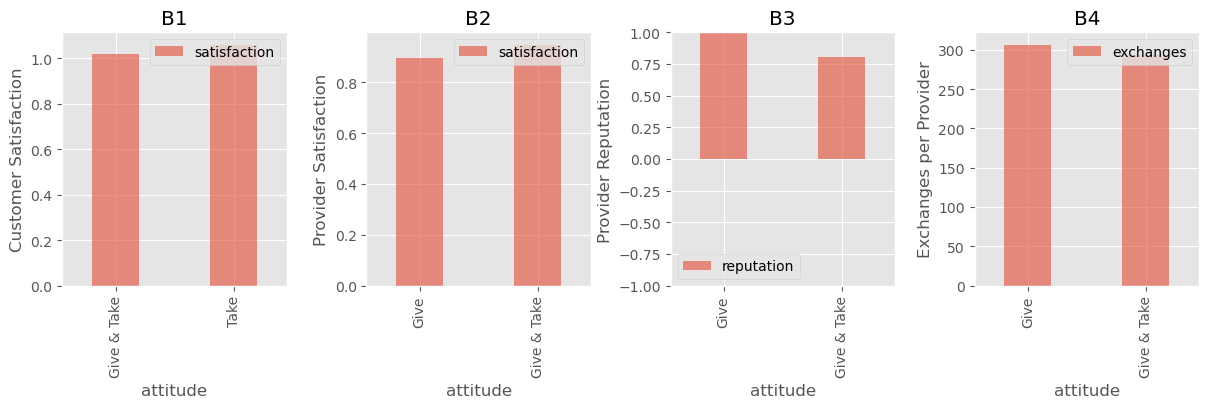

In [36]:
sim = Simulation(
    customer_counts = {ATTITUDE_GIVE_AND_TAKE: 216, ATTITUDE_TAKE: 24},
    provider_counts = {ATTITUDE_GIVE_AND_TAKE: 40, ATTITUDE_GIVE: 40},
    rating_periods = 100,
    interactions_per_exchange = 25
    )
sim.simulate()
plot_by_competence(sim)
plot_by_attitude(sim)

### Simulation 3 commentary 

A1 shows a distribution of reputations that is similar to many sharing economy reputation systems: a large number of top-rated providers, and a few who are rated slightly less than perfect. A3 shows that the distinction has nothing to do with provider competence, but is shaped by the provider's attitude, with a "Give" attitude leading to a higher reputation than a "Give & Take" attitude. 

Those providers who look for a reciprocal relationship get thumbs up from similar customers, but they get thumbs down from the entitled customers: after the provider response to the customer's initial TAKE with a TAKE of their own, the relationship goes sour and settles in to a low-scoring "Take - Take" trap. Those providers who are indulgent ("Give") get exploited: they have to put up with the continual Take choices of the customer with a smile, but do get rewarded with a higher reputation (A3, B3), and so get a little more business (A4, B4).

A2 and B2 shows that the reciprocal providers have a slightly better experience than compliant providers.

B1 shows that the two customer types have a similar level of satisfaction. The reciprocal customers do well with all providers, while the entitled customers do less well with the reciprocal providers (they do not get along), but happily exploit the indulgence of the compliant providers.

So what is happening here is just what we see in most service reputation systems. From the point of view of the rating system provider itself, this is a better result: the entitled customers are the ones behaving just as they should - not being biased by their relationship with the service provider, delivering an "honest" assessment of the quality of their experience. The collaborative customers, building a relationship with the provider, and reluctant to snitch on them through the rating system, are the ones that are in the wrong from the reputation system point of view.

Seen from anywhere other than the perspective of the platform provider, this setup panders to demanding consumers by requiring service providers to engage in emotional labour.

## Simulation 4: more "honest" customers

This final simulation increases the proportion of entitled customers (or "honest raters" as the platform provider would see it) to see what happens as the rating system "improves".

If Simulation 3 describes the way that reputation systems currently work, Simulation 4 describes the way that the platform owners (sharing economy companies and rating providers) would like them to work: they expect customers to be "honest" - report good and bad experiences, and to maintain an emotional distance from their service provider (to avoid "bias"). These ideal customers are not committed to the social exchange (not "Give & Take"), but instead treat the experience as one to be judged.

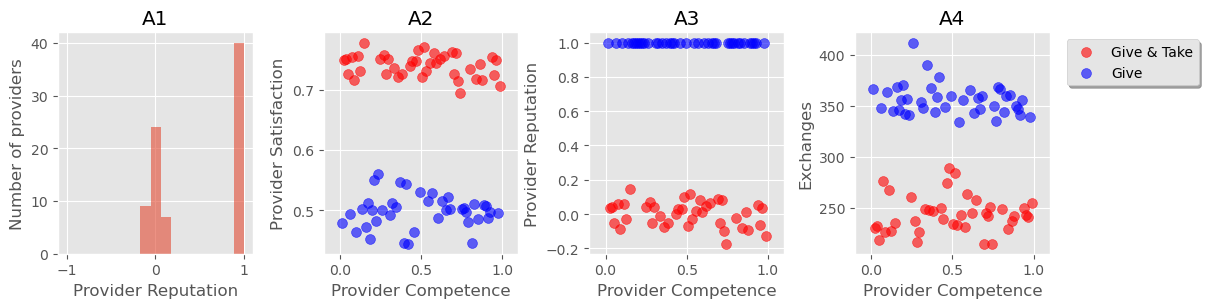

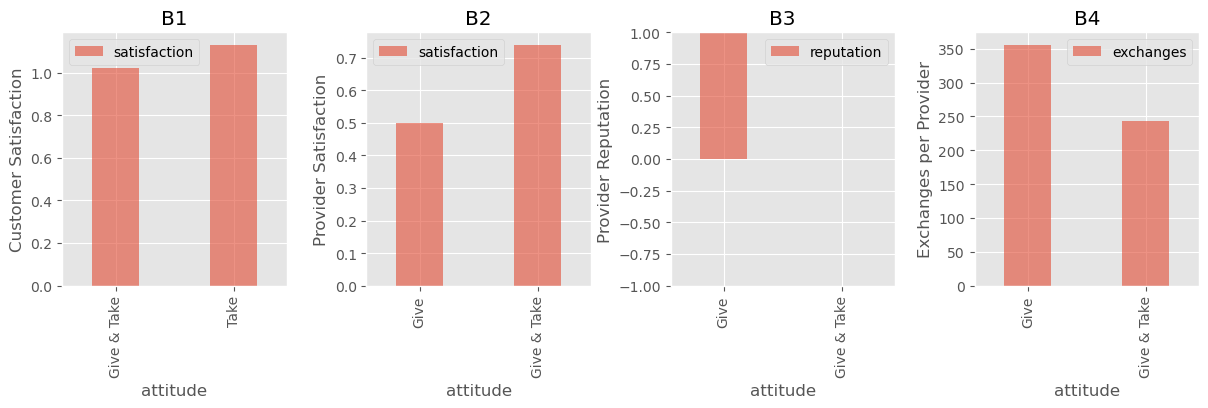

In [37]:
sim = Simulation(
    customer_counts = {ATTITUDE_GIVE_AND_TAKE: 120, ATTITUDE_TAKE: 120},
    provider_counts = {ATTITUDE_GIVE_AND_TAKE: 40, ATTITUDE_GIVE: 40},
    rating_periods = 100,
    interactions_per_exchange = 25
    )
sim.simulate()
plot_by_competence(sim)
plot_by_attitude(sim)

### Simulation 4 commentary

The split between Give & Take providers and compliant providers has grown. A2 and B2 show that compliant providers are having a miserable experience (their satisfaction is lower than that of the Give & Take providers), but their reputation is a lot better (thanks to the entitled customers) and so their business prospers do better (more exchanges). The compliant providers are ruling the roost.
B1 shows that entitled customers are having more satisfying experiences. The high reputation for compliant providers is rewarded with higher traffic, and entitled customers do very well from compliant providers by exploiting their indulgent behaviour.

# Conclusion

The fact that Simulation 2 gives a rating distribution far more like current sharing economy reputation systems than Simulation 1 demonstrates the important role of social exchange compared to a pure market or transactional exchange in most customer--service provider exchanges. It is this social exchange that is at the root of the Lake Wobegon effect, where all providers are above average. Reputation systems do indeed fail to discriminate on the basis of competence (quality).

Simulation 3 shows that a small number of entitled customers can induce a Panopticon effect. Service providers who engage in Give & Take exchanges with their customers (even very competent ones) risk being given a negative review, which will damage their business. The incentives of the reputation system encourage providers to indulge their customers, in order to avoid this unlikely but damaging judgement.

Simulation 4 shows that, if reputation systems spread and customers become used to rating people in an "honest" fashion, we are building a terrible world for service providers. They must engage in emotional labour, catering to customer whims, or risk their livelihood. The Panopticon is here. The reputation systems continue to fail, it should be noted, to discriminate based on the competence of the service provider -- instead of changing quality, they change attitude.

The Lake Wobegon effect and the Panopticon effect can coexist, and are coexisting. Reputation systems as they currently stand are failing to discriminate based on quality. But there is only one thing worse than a reputation system that doesn't work, and that's a reputation system that works: Simulation 4 shows a dystopic future for service providers, in which their careers are being shaped by reputation systems that are not working as advertised, but are working to compel compliance.